In [1]:
import os
import numpy as np
import tensorflow_probability as tfp
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
mnist2 = input_data.read_data_sets('MNIST_data/')

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [4]:
mnist2.test.images[0]
len(mnist2.test.images)
len(mnist2.test.images[0])

784

In [6]:
mnist2.test.labels
len(mnist2.test.labels)

10000

In [7]:
tfd = tfp.distributions
input_size = 28 * 28

decoder_std = 0.5
epochs = 150
batch_size = 128

In [8]:
class VAE(object):
    def __init__(self, learning_rate=0.001, decoder_std = 0.5, latent_dim=2):
        #set hyperparameters
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, input_size])
        self.learning_rate = learning_rate
        self.decoder_std = decoder_std
        self.latent_dim = latent_dim
        
        self.build()
        
        #Initialize parameters
        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def encoder(self, x):
        x1 = tf.layers.dense(x, 256, activation=tf.nn.relu)
        x2 = tf.layers.dense(x1, 256, activation=tf.nn.relu)
        self.mu = tf.layers.dense(x2, self.latent_dim)
        self.scale = tf.layers.dense(x2, self.latent_dim)
        std = tf.sqrt(1e-5 + tf.exp(self.scale))
        return self.mu, std
    
    def prior(self):
        loc = tf.zeros(self.latent_dim)
        scale = tf.ones(self.latent_dim)
        return tfd.MultivariateNormalDiag(loc, scale)
    
    def decoder(self, z, input_size=28*28): #input_size=784
        z1 = tf.layers.dense(z, 256, activation=tf.nn.relu)
        z2 = tf.layers.dense(z1, 256, activation=tf.nn.relu)
        mu = tf.layers.dense(z2, input_size)
        decoder_std = tf.sqrt(1e-5 + tf.exp(tf.layers.dense(z2, input_size, tf.nn.softplus)))
        return mu, decoder_std

    
    def build(self):
        
        self.encoder = tf.make_template('encoder', self.encoder)
        self.decoder = tf.make_template('decoder', self.decoder)
        
        #encode an image into the distribution of latent space
        self.encoder_mu, self.encoder_std = self.encoder(self.x)

        #sample by reparametrisation
        eps = tf.random_normal(shape=[tf.shape(self.x)[0], self.latent_dim], mean=0.0, stddev=1.0, dtype=tf.float32)
        self.z = self.encoder_mu + self.encoder_std*eps

        #decode latent vector z
        self.decoder_mu, self.decoder_std = self.decoder(self.z)

        
        self.posterior = tfd.MultivariateNormalDiag(self.encoder_mu, self.encoder_std)
        prior = self.prior()
        
        decoder_samp_mu, decoder_samp_std = self.decoder(prior.sample(15))
        
        self.samples = tfd.Independent(tfd.MultivariateNormalDiag(decoder_samp_mu, decoder_samp_std)).mean()
        
        #reconstruction loss
        self.likelihood = tfd.Independent(tfd.MultivariateNormalDiag(self.decoder_mu, self.decoder_std)).log_prob(self.x)

        
        #KL divergence loss
        self.divergence = tfd.kl_divergence(self.posterior, prior)
        self.elbo = tf.reduce_mean(self.likelihood - self.divergence, axis=0)
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).minimize(-self.elbo)
        return

    def run(self, x):
        self.sess.run(self.optimize, feed_dict={self.x: x})
        return
    
    
    def plot_latent(self, z=[], labels=[]):
        plt.figure(figsize=(5, 4))
        plt.scatter(z[:, 0], z[:, 1], c=labels, s=20)
        plt.xlim(z.min() - .1, z.max() + .1)
        plt.ylim(z.min() - .1, z.max() + .1)
        plt.grid()
        
    def plot_reconstruction(self, x, mnist, h=28, w=28):
        x_reconstructed = x
        n = 15
        I_reconstructed = np.empty((h*1, 2*w*n))
        for i in range(n):
            x = np.concatenate(
                (x_reconstructed[i, :].reshape(h, w), 
                mnist[i, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[0:h, i*2*w:(i+1)*2*w] = x
        plt.figure(figsize=(10, 20))
        plt.imshow(I_reconstructed, cmap='gray')
    
    def plot_samples(self, ax=[], samples=[]):
        for index, sample in enumerate(samples):
            ax[index].imshow(sample, cmap='gray')
            ax[index].axis('off')
 

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Epoch 0 elbo 1015.3872
Epoch 1 elbo 744.65485
Epoch 2 elbo 743.4877
Epoch 3 elbo 743.00946
Epoch 4 elbo 742.775
Epoch 5 elbo 742.62085
Epoch 6 elbo 742.4147
Epoch 7 elbo 742.2411
Epoch 8 elbo 742.1733
Epoch 9 elbo 741.9988
Epoch 10 elbo 741.81104
Epoch 11 elbo 741.7439
Epoch 12 elbo 741.62524
Epoch 13 elbo 741.52496
Epoch 14 elbo 741.3921
Epoch 15 elbo 741.3384
Epoch 16 elbo 741.15186
Epoch 17 elbo 741.1667
Epoch 18 elbo 741.0156
Epoch 19 elbo 741.1294
Epoch 20 elbo 740.8953
Epoch 21 elbo 740.9432
Epoch 22 elbo 740.845
Epoch 23 elbo 740.8188
Epoch 24 elbo 740.88855
Epoch 25 elbo 740.8867
Epoch 26 elbo 740.7852
Epoch 27 elbo 740.7929
Epoch 28 elbo 740.71844
Epoch 29 elbo 740.5869
Epoch 30 elbo 740.6734
Epoch 31 elbo 740.71155
Epoch 32 elbo 740.6008
Epoch 33 elbo 740.4633
Ep

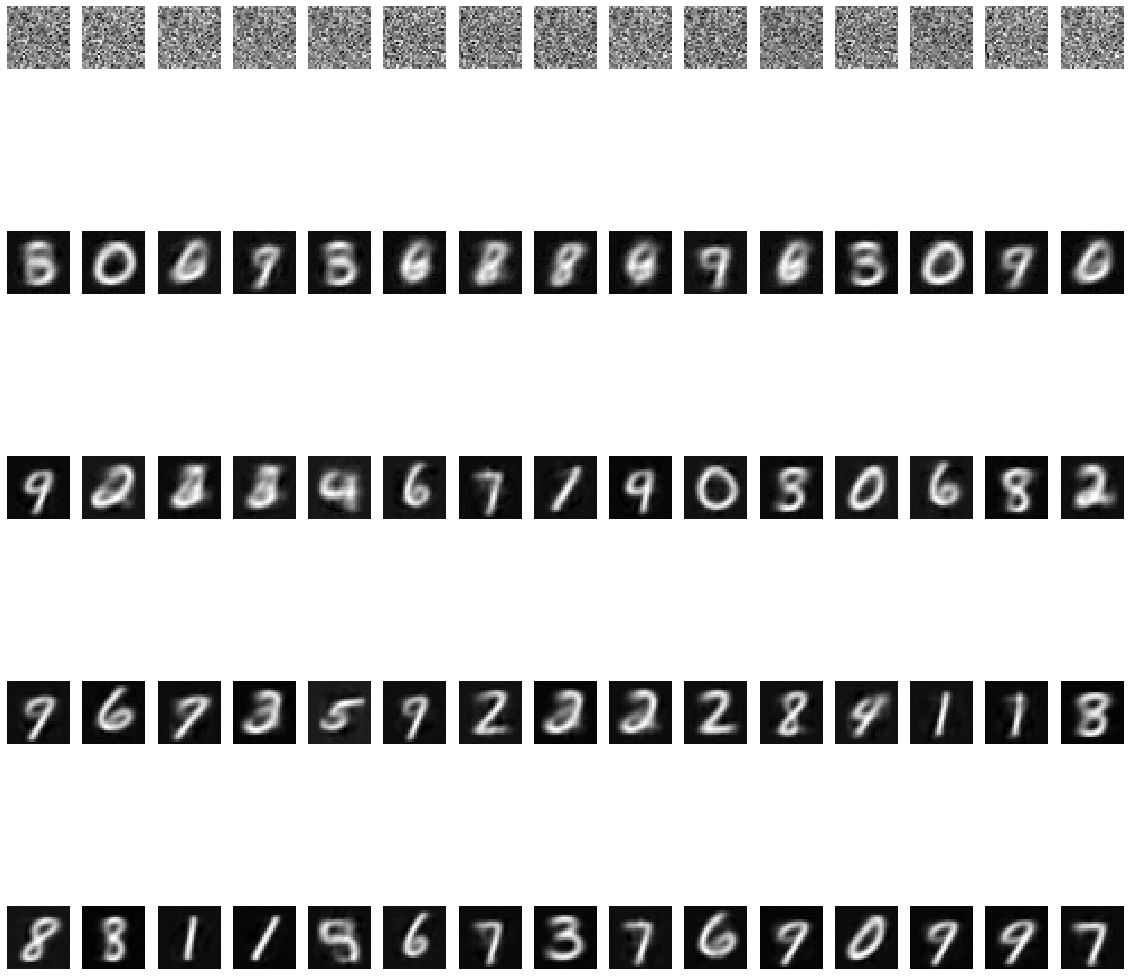

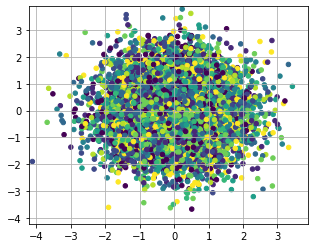

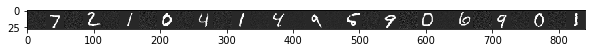

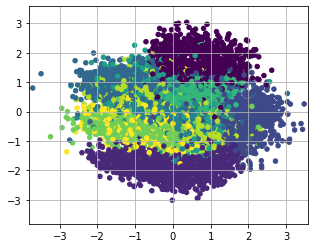

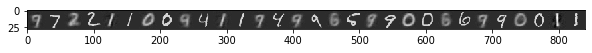

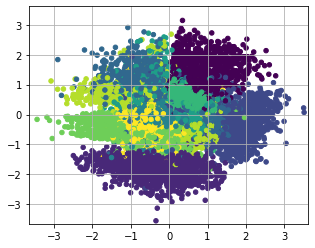

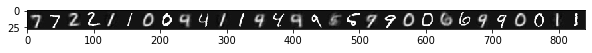

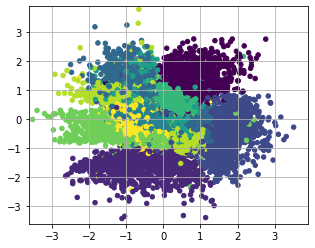

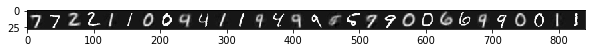

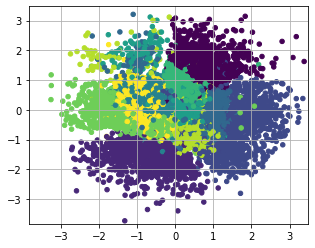

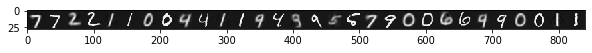

In [9]:
model = VAE(learning_rate=0.001, decoder_std=0.5, latent_dim=2)
fig, ax = plt.subplots(nrows=5, ncols=15, figsize=(20, 20))
i = 0
stop_epoch = 0
elbo = []

for epoch in range(epochs):
    feed = {model.x: mnist2.test.images}
    #likelihood = model.sess.run([model.likelihood], feed)
    #print('likelihood', likelihood)
    test_elbo, test_z, test_samples, test_decoder_mu =  model.sess.run(
        [model.elbo, model.z, model.samples, model.decoder_mu], feed)
    elbo.append(-test_elbo)
    print('Epoch', epoch, 'elbo', -test_elbo)
    
    
    #set stop training criteria
    if epoch == 0:
        min_elbo = -test_elbo
    elif -test_elbo < min_elbo:
        min_elbo = -test_elbo
        stop_epoch = 0
    elif -test_elbo > min_elbo:
        stop_epoch+=1
    
    if stop_epoch > 10:
        print('stop at epoch', epoch)
        model.plot_latent(test_z, mnist2.test.labels)
        model.plot_reconstruction(test_decoder_mu,mnist2.test.images)
        ax[i, 0].set_ylabel('Epoch {}'.format(epoch))
        test_samples = test_samples.reshape([-1, 28, 28])
        model.plot_samples(ax[i, :], test_samples)
        break
    
    
    #plot latent representation    
    if epoch in [0, 4, 24, 49]:    
        model.plot_latent(test_z, mnist2.test.labels)
        model.plot_reconstruction(test_decoder_mu,mnist2.test.images)
        ax[i, 0].set_ylabel('Epoch {}'.format(epoch))
        test_samples = test_samples.reshape([-1, 28, 28])
        model.plot_samples(ax[i, :], test_samples)
        i+=1
        
    #training step 
    for _ in range(mnist2.train.num_examples // batch_size):
        batch = mnist2.train.next_batch(batch_size)[0]
        model.run(batch)
        
print('train stop!')

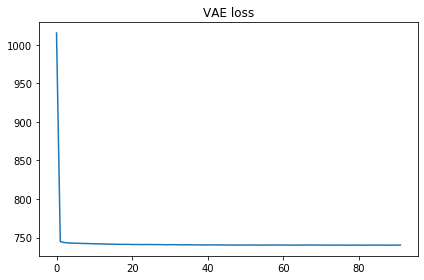

In [14]:
#2-dim latent space loss curve
plt.plot(elbo)
plt.title('VAE loss')
plt.tight_layout()

Epoch 0 elbo 1026.0642
Epoch 1 elbo 746.34985
Epoch 2 elbo 743.3739
Epoch 3 elbo 742.1541
Epoch 4 elbo 741.58026
Epoch 5 elbo 741.2568
Epoch 6 elbo 740.8628
Epoch 7 elbo 740.79785
Epoch 8 elbo 740.65784
Epoch 9 elbo 740.50305
Epoch 10 elbo 740.3471
Epoch 11 elbo 740.2643
Epoch 12 elbo 740.1894
Epoch 13 elbo 740.0588
Epoch 14 elbo 739.9731
Epoch 15 elbo 740.0138
Epoch 16 elbo 739.9065
Epoch 17 elbo 739.8688
Epoch 18 elbo 739.7685
Epoch 19 elbo 739.7503
Epoch 20 elbo 739.66785
Epoch 21 elbo 739.6556
Epoch 22 elbo 739.6114
Epoch 23 elbo 739.6432
Epoch 24 elbo 739.5079
Epoch 25 elbo 739.5453
Epoch 26 elbo 739.50226
Epoch 27 elbo 739.4842
Epoch 28 elbo 739.4321
Epoch 29 elbo 739.4731
Epoch 30 elbo 739.3713
Epoch 31 elbo 739.4367
Epoch 32 elbo 739.3619
Epoch 33 elbo 739.3276
Epoch 34 elbo 739.2676
Epoch 35 elbo 739.3264
Epoch 36 elbo 739.2396
Epoch 37 elbo 739.3007
Epoch 38 elbo 739.2798
Epoch 39 elbo 739.2731
Epoch 40 elbo 739.2324
Epoch 41 elbo 739.22754
Epoch 42 elbo 739.285
Epoch 43 elbo

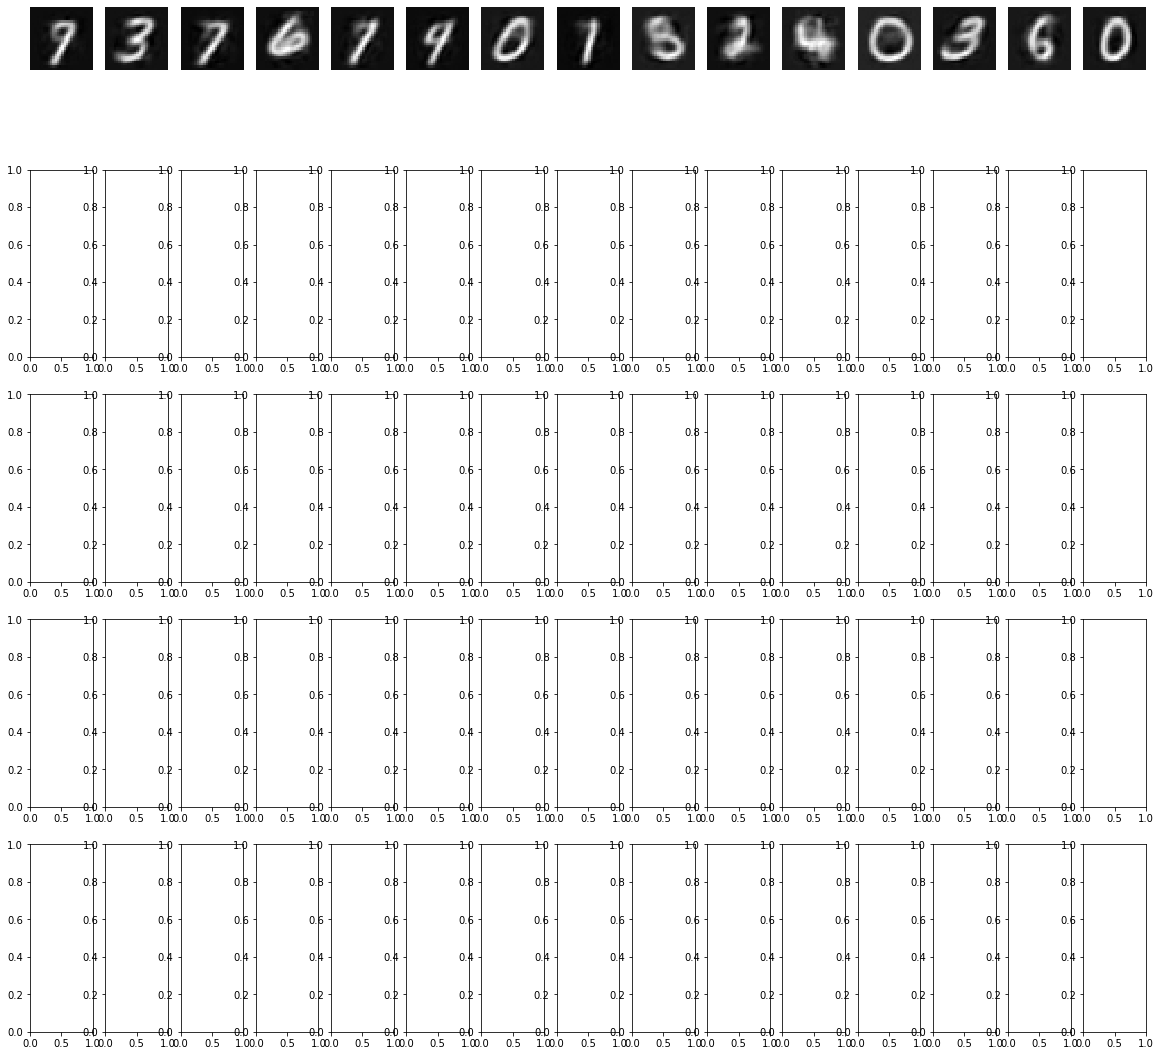

In [19]:
model_2 = VAE(learning_rate=0.001, decoder_std=0.5, latent_dim= 32)
fig2, ax2 = plt.subplots(nrows=5, ncols=15, figsize=(20, 20))
i = 0
stop_epoch = 0
elbo_2 = []

for epoch in range(epochs):
    feed = {model_2.x: mnist2.test.images}
    #likelihood = model_2.sess.run([model_2.likelihood], feed)
    #print('likelihood', likelihood)
    test_elbo, test_z, test_samples, test_decoder_mu =  model_2.sess.run(
        [model_2.elbo, model_2.z, model_2.samples, model_2.decoder_mu], feed)
    elbo_2.append(-test_elbo)
    print('Epoch', epoch, 'elbo', -test_elbo)
    
    
    #set stop training criteria
    if epoch == 0:
        min_elbo = -test_elbo
    elif -test_elbo < min_elbo:
        min_elbo = -test_elbo
        stop_epoch = 0
    elif -test_elbo > min_elbo:
        stop_epoch+=1
    
    if stop_epoch > 10:
        print('stop at epoch', epoch)
        #model_2.plot_latent(test_z, mnist2.test.labels)
        #model_2.plot_reconstruction(test_decoder_mu,mnist2.test.images)
        #ax2[i, 0].set_ylabel('Epoch {}'.format(epoch))
        test_samples = test_samples.reshape([-1, 28, 28])
        model_2.plot_samples(ax2[i, :], test_samples)
        break
    
    
    #plot latent representation    
    #if epoch in [0, 4, 24, 49]:    
    #    model_2.plot_latent(test_z, mnist2.test.labels)
    #    model_2.plot_reconstruction(test_decoder_mu,mnist2.test.images)
    #    ax2[i, 0].set_ylabel('Epoch {}'.format(epoch))
    #    test_samples = test_samples.reshape([-1, 28, 28])
    #    model_2.plot_samples(ax2[i, :], test_samples)
    #    i+=1
        
    #training step 
    for _ in range(mnist2.train.num_examples // batch_size):
        batch = mnist2.train.next_batch(batch_size)[0]
        model_2.run(batch)
        
print('train stop!')

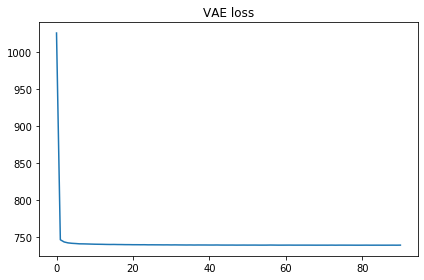

In [20]:
#32-dim latent space loss curve
plt.plot(elbo_2)
plt.title('VAE loss')
plt.tight_layout()